# Assignment 3

In this assignment, you will refactor the code from the lecture by...
1. Adding a train-validation split.
2. Using `nn.Module` for defining the model.
3. Implementing the training loop.

## Importing Libraries

In [18]:
import os
import sys

project_path = r"C:\\Users\\delta\\Documents\\GitHub\\LLM101n"
sys.path.insert(0, project_path)

In [19]:
import os
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple
import torch
from torch import nn
from torch.nn import functional as F
from utils import load_text, set_seed, configure_device
%matplotlib inline

## Configuration

**Note:** If you do not have a GPU, decrease the `max_steps`

In [20]:
@dataclass
class MLPConfig:
    root_dir: str = os.getcwd() + "/../../"
    dataset_path: str = "data/names.txt"
    device: torch.device = torch.device('cpu')  # Automatic device configuration

    # Tokenizer
    vocab_size: int = 0  # Set later
    
    # Model
    context_size: int = 3
    d_embed: int = 16
    d_hidden: int = 64
    
    # Training
    val_size: float = 0.1
    batch_size: int = 32
    max_steps: int = 10000
    lr: float = 2e-3
    val_interval: int = 1000

    seed: int = 101
    
config = MLPConfig()
    

## Reproducibility

In [21]:
set_seed(config.seed)
generator = torch.Generator().manual_seed(config.seed)

Random seed set to 101


## Device

In [22]:
config.device = configure_device()

Running on cpu


## Tokenizer

In [23]:
chars = [chr(i) for i in range(97, 123)]  # all alphabet characters
chars.insert(0, ".")  # Add special token
config.vocab_size = len(chars)
str2idx = {char: idx for idx, char in enumerate(chars)}
idx2str = {idx: char for char, idx in str2idx.items()}

## Dataset

In [24]:
names = load_text(config.root_dir + config.dataset_path).splitlines()

Loaded text data from c:\Users\delta\Documents\GitHub\LLM101n\notebooks\Assignments/../../data/names.txt (length: 228145 characters).


## Preprocessing

### Task 1: Train-Validation split

Using all the data for training leads to overfitting.

Implement a function to split the text into training and validation sets. 

In [25]:
def split_names(_names: str, val_size: float) -> Tuple[str, str]:
    """
    Split text into training and validation sets.

    Args:
        _names (str): The data to split.
        val_size (float): Size of the validation set.

    Returns:
        Tuple[str, str]: Training and validation data.
    """
    if val_size <= 0 or val_size >= 1:
        raise ValueError(f"Invalid validation size: {val_size}")
    ################################################################################
    # TODO:                                                                        #
    # Split the data into training and validation sets.                            #
    ################################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
    # 전체 데이터 개수에서 검증 샘플 수 계산
    n_val = int(len(_names) * val_size)

    indices = torch.randperm(len(_names), generator=generator)
    
    # 앞쪽 n_val개를 검증 데이터 인덱스로 사용
    val_indices = indices[:n_val]
    train_indices = indices[n_val:]
    
    # 인덱스를 기반으로 데이터 분할
    train_text = [_names[i] for i in train_indices]
    val_text = [_names[i] for i in val_indices]
    
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return train_text, val_text

In [26]:
train_names, val_names = split_names(names, config.val_size)
print(f"Training set size: {len(train_names)}")
print(f"Validation set size: {len(val_names)}")

Training set size: 28830
Validation set size: 3203


In [27]:
def prepare_dataset(_names):
    inputs, targets = [], []

    for name in _names:
        context = [0] * config.context_size
        
        for char in name + ".":
            idx = str2idx[char]
            inputs.append(context)
            targets.append(idx)
            context = context[1:] + [idx]  # Shift the context by 1 character

    inputs = torch.tensor(inputs)
    targets = torch.tensor(targets)
    
    return inputs, targets

In [28]:
train_inputs, train_targets = prepare_dataset(train_names)
val_inputs, val_targets = prepare_dataset(val_names)

## Model

### Task 2: `nn.Module`.

PyTorch provides a module called `nn.Module` for defining models. Instead of defining every layer as a separate tensor, we can wrap it all up in a class. This provides better organization and encapsulation.

[PyTorch Documentation](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)

Implement a class `MLP` that inherits from `nn.Module`.
(Hint: You can use `nn.Embedding` and `nn.Linear`)


In [29]:
class MLP(nn.Module):
    ################################################################################
    # TODO:                                                                        #
    # Define the __init__ and forward methods for the MLP model.                   #
    ################################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    def __init__(self, vocab_size, context_size, d_embed, d_hidden):
        super().__init__()
        
        # nn.Embedding
        self.embedding = nn.Embedding(vocab_size, d_embed)
        # first nn.Linear
        self.fc1 = nn.Linear(context_size * d_embed, d_hidden)
        # second nn.Linear
        self.fc2 = nn.Linear(d_hidden, vocab_size)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x (torch.Tensor): (batch_size, context_size) 형태의 텐서, 각 행은 토큰 인덱스들의 시퀀스.
        
        Returns:
            torch.Tensor: (batch_size, vocab_size) 형태의 로짓 텐서.
        """
        x = self.embedding(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        logits = self.fc2(x)
        
        return logits

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    # Note: do not include softmax in the forward pass since it is already included in the loss function.

In [30]:
# Initialize the model
mlp = MLP(config.vocab_size, config.context_size, config.d_embed, config.d_hidden)
mlp.to(config.device) # Move the model to the device
print(mlp)
print("Number of parameters:", sum(p.numel() for p in mlp.parameters()))

# Example forward pass
example_input = train_inputs[:2]
example_input = example_input.to(config.device)  # Move the data to the device
print(f"Input shape: {example_input.shape}")
print(f"Output shape: {mlp(example_input).shape}")

MLP(
  (embedding): Embedding(27, 16)
  (fc1): Linear(in_features=48, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=27, bias=True)
)
Number of parameters: 5323
Input shape: torch.Size([2, 3])
Output shape: torch.Size([2, 27])


## Training

### Task 3: Training loop.

Implement the training loop for the model.

What is an optimizer? [PyTorch Documentation](https://pytorch.org/docs/stable/optim.html)

In [31]:
def train(model):
    steps = []
    train_losses = []
    val_losses = []
    
    # Define the optimizer
    ################################################################################
    # TODO:                                                                        #
    # Define the optimizer for the model.                                          #
    # Use stochastic gradient descent (SGD) with the learning rate from the config.#
    ################################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    optimizer = torch.optim.SGD(model.parameters(), lr=config.lr)
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
    for step in range(1, config.max_steps + 1):
        # Training
        # Sample batch
        idx = torch.randperm(len(train_inputs))[:config.batch_size]
        x, y = train_inputs[idx], train_targets[idx]
        x, y = x.to(config.device), y.to(config.device)  # Move the data to the device
        
        ################################################################################
        # TODO:                                                                        #
        # Implement the forward pass and the backward pass                             #
        ################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # Forward pass
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        # Validation
        if step % config.val_interval == 0:
            # Validation loss
            with torch.no_grad():
                val_logits = model(val_inputs.to(config.device))
                val_loss = F.cross_entropy(val_logits, val_targets.to(config.device)).item()
                val_losses.append(val_loss)
            
        # Logging
        steps.append(step)
        train_losses.append(loss.item())
        if step % config.val_interval == 0:
            print(f"Step {step}: Train Loss = {loss.item():.4f}, Val Loss = {val_loss:.4f}")

    # Plot the loss
    plt.figure()
    plt.plot(steps, train_losses, label="Train")
    plt.plot(steps[::config.val_interval], val_losses, label="Validation")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

Step 1000: Train Loss = 2.7889, Val Loss = 2.9404
Step 2000: Train Loss = 2.8122, Val Loss = 2.7841
Step 3000: Train Loss = 2.6341, Val Loss = 2.7044
Step 4000: Train Loss = 2.8454, Val Loss = 2.6530
Step 5000: Train Loss = 2.4776, Val Loss = 2.6158
Step 6000: Train Loss = 2.8658, Val Loss = 2.5863
Step 7000: Train Loss = 2.4723, Val Loss = 2.5632
Step 8000: Train Loss = 2.6030, Val Loss = 2.5437
Step 9000: Train Loss = 2.7700, Val Loss = 2.5275
Step 10000: Train Loss = 2.4140, Val Loss = 2.5138


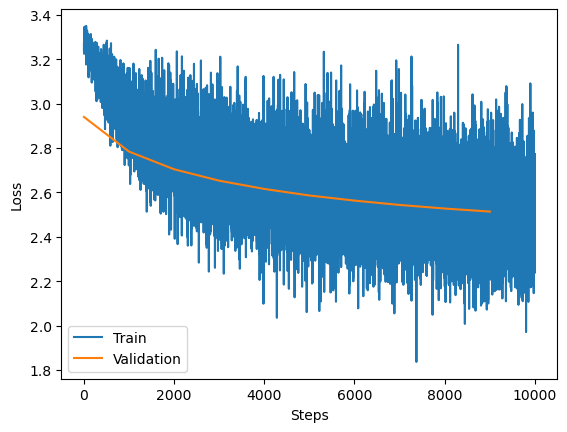

In [32]:
train(mlp)

## Inference

In [33]:
def generate_name():
    new_name = []
    context = [0] * config.context_size
    
    while True:
        # forward pass
        x = torch.tensor(context).unsqueeze(0).to(config.device)
        logits = mlp(x)
        
        # sample
        probs = F.softmax(logits, dim=-1)
        idx = torch.multinomial(probs, num_samples=1).item()
        
        # update context
        new_name.append(idx2str[idx])
        context = context[1:] + [idx]
        
        # break if "."
        if idx == 0:
            break
        
    return "".join(new_name)

In [34]:
for _ in range(5):
    print(generate_name())

lmenla.
attly.
hil.
alna.
laesit.


## Extra Credit

Change the model configuration and hyperparameters to achieve the following:

Generate good-looking names and get the lowest **validation loss** as possible.

Rules:
- Do not change the random seed.
- Do not change the validation set size.
- External data is not allowed.